In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re


pjr.py complete


test latex syntax $a = b^2$

In [36]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [60]:
from matplotlib import gridspec
def setup3 ():
    fig = plt.figure(figsize=(6, 9)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    ax1 = plt.subplot(gs[2],projection=ccrs.Robinson())
    ax1.set_global() # make axis consistent with projection limits
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.Robinson())
    ax2.set_global() # make axis consistent with projection limits
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
    print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


seas ANN
jname1 /global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850aeroF.ne30_oEC.edison/archive/atm/climo/rgr/20180716.DECKv1b_A3_1850aeroF.ne30_oEC.edison_ANN_198001_200412_climo.nc
g1 varlist ['SH_WCLDBASE', 'SH_KCLDBASE', 'CLDLOW_CAL_LIQ', 'CLDMED_CAL', 'CLDHGH_CAL_UN', 'CLDTOT_CAL_ICE', 'DP_KCLDBASE', 'CLDLIQ', 'CLDTOT_CAL_LIQ', 'CLDLOW_CAL', 'CLDMED_CAL_ICE', 'CLDLOW_CAL_UN', 'CLDTOT_ISCCP', 'CLDTOT_CAL', 'CLD_CAL', 'CLDHGH_CAL', 'CLDMED', 'CLDLOW', 'CLDTOT', 'CLDLOW_CAL_ICE', 'MEANCLDALB_ISCCP', 'CLDHGH', 'TGCLDLWP', 'CLDHGH_CAL_ICE', 'CLDICE', 'CLDTOT_CAL_UN', 'TGCLDCWP', 'TGCLDIWP', 'DP_WCLDBASE', 'CLDHGH_CAL_LIQ', 'CLDMED_CAL_UN', 'CLD_MISR', 'CONCLD', 'CLDMED_CAL_LIQ']
jname2 /global/cscratch1/sd/pjr/20180716.DECKv1b_A3.ne30_oEC.edison/archive/atm/climo/rgr/20180716.DECKv1b_A3.ne30_oEC.edison_ANN_198001_200412_climo.nc
i AEROD_v
land only GA1 0.14168707579857395
ocean only GA1 0.12788797016262812
sea ice only GA1 0.052072509470302675
land only GA2 0.17834622681585047
ocean onl

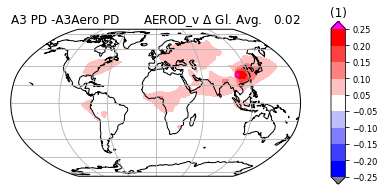

done withAer Opt Depth



i CLDHGH
land only GA1 0.39385590243630736
ocean only GA1 0.38274109732109707
sea ice only GA1 0.35590228344005265
land only GA2 0.3947187118414943
ocean only GA2 0.3849605137369827
sea ice only GA2 0.3524642591875533
GA1, GA2, DG 0.38498418657988137 0.38658916481565225 0.001604978235770882
DT.id CLDHGH
pltframe
pltframe plotOpt clevs [-0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04]
data range -0.034781694 0.04842186
pltframe final clevs [-0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04]
pltframe done
figure being saved to  workdir/Test_Roblatlon_CLDHGH_ANN_FDIFS.pdf


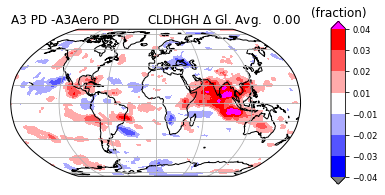

done withCLDHGH



i CLDLOW
land only GA1 0.2945914025370404
ocean only GA1 0.46130053170653723
sea ice only GA1 0.8122896153182645
land only GA2 0.3041097402342844
ocean only GA2 0.462005389335948
sea ice only GA2 0.8239314629903898
GA1, GA2, DG 0.4256910246304368 0.4294031636296279 0.0037121389991910947
DT.id CLDLOW
pltframe
pltframe plotOpt clevs [-0.05 -0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04  0.05]
data range -0.030046523 0.057430357
pltframe final clevs [-0.05 -0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04  0.05]
pltframe done
figure being saved to  workdir/Test_Roblatlon_CLDLOW_ANN_FDIFS.pdf


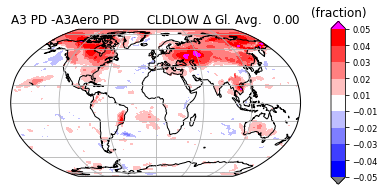

done withCLDLOW



i CLDMED
land only GA1 0.32053697741857895
ocean only GA1 0.23157997077764256
sea ice only GA1 0.5149746538619343
land only GA2 0.3248544673146864
ocean only GA2 0.2333089666809126
sea ice only GA2 0.5210505702953869
GA1, GA2, DG 0.2685307994009318 0.27118630004652927 0.002655500645597497
DT.id CLDMED
pltframe
pltframe plotOpt clevs [-0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005  0.005  0.01   0.015
  0.02   0.025  0.03   0.035]
data range -0.025747836 0.03715062
pltframe final clevs [-0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005  0.005  0.01   0.015
  0.02   0.025  0.03   0.035]
pltframe done
figure being saved to  workdir/Test_Roblatlon_CLDMED_ANN_FDIFS.pdf


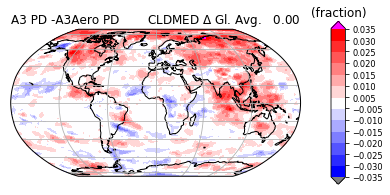

done withCLDMED



i CLDTOT
land only GA1 0.611181034705867
ocean only GA1 0.6923134903906552
sea ice only GA1 0.8923084211923007
land only GA2 0.6189553112833875
ocean only GA2 0.6950050042024563
sea ice only GA2 0.8993753326941802
GA1, GA2, DG 0.6760961354754668 0.6804482828987699 0.004352147423303143
DT.id CLDTOT
pltframe
pltframe plotOpt clevs [-0.05 -0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04  0.05]
data range -0.029896975 0.051169634
pltframe final clevs [-0.05 -0.04 -0.03 -0.02 -0.01  0.01  0.02  0.03  0.04  0.05]
pltframe done
figure being saved to  workdir/Test_Roblatlon_CLDTOT_ANN_FDIFS.pdf


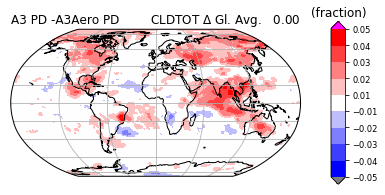

done withCLDTOT



i FLNT
land only GA1 232.5156149715679
ocean only GA1 245.52209648311145
sea ice only GA1 193.65887342088342
land only GA2 231.56453975968984
ocean only GA2 244.89742841585684
sea ice only GA2 193.10697880649502
GA1, GA2, DG 239.72182138469105 239.004000166127 -0.7178212185640405
DT.id FLNT
pltframe
pltframe plotOpt clevs [-7. -6. -5. -4. -3. -2. -1.  1.  2.  3.  4.  5.  6.  7.]
data range -7.5795593 3.174881
pltframe final clevs [-7. -6. -5. -4. -3. -2. -1.  1.  2.  3.  4.  5.  6.  7.]
pltframe done
figure being saved to  workdir/Test_Roblatlon_FLNT_ANN_FDIFS.pdf


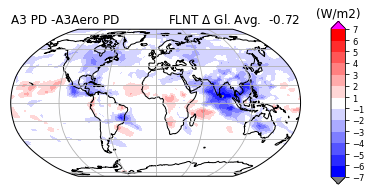

done withFLNT



i FLNTC
land only GA1 254.09488669122504
ocean only GA1 270.76992102883844
sea ice only GA1 212.01897448032372
land only GA2 253.7542551253348
ocean only GA2 270.6561962802088
sea ice only GA2 212.71085933444147
GA1, GA2, DG 263.62883252367914 263.47914354056223 -0.14968898311690282
DT.id FLNTC
pltframe
pltframe plotOpt clevs [-3.  -2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5  3. ]
data range -3.0069275 2.2210236
pltframe final clevs [-3.  -2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5  3. ]
pltframe done
figure being saved to  workdir/Test_Roblatlon_FLNTC_ANN_FDIFS.pdf


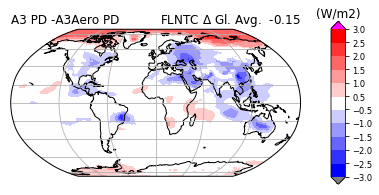

done withFLNTC



i FSNT
land only GA1 217.50189406674014
ocean only GA1 260.8188792483357
sea ice only GA1 90.7887172688639
land only GA2 214.09762700469284
ocean only GA2 258.5593566595143
sea ice only GA2 88.94933306623602
GA1, GA2, DG 241.6043709945163 239.02443995073912 -2.5799310437771794
DT.id FSNT
pltframe
pltframe plotOpt clevs [-15. -10.  -5.   5.  10.  15.]
data range -17.839935 2.6811218
pltframe final clevs [-15. -10.  -5.   5.  10.  15.]
pltframe done
figure being saved to  workdir/Test_Roblatlon_FSNT_ANN_FDIFS.pdf


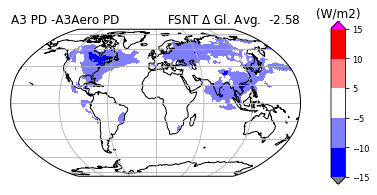

done withFSNT



i FSNTC
land only GA1 252.65104573529385
ocean only GA1 314.7098327321452
sea ice only GA1 121.53984148565392
land only GA2 251.81187371578903
ocean only GA2 314.17105335455955
sea ice only GA2 120.53732701452567
GA1, GA2, DG 289.10484867382314 288.4601021640778 -0.644746509745346
DT.id FSNTC
pltframe
pltframe plotOpt clevs [-7. -6. -5. -4. -3. -2. -1.  1.  2.  3.  4.  5.  6.  7.]
data range -7.5761185 5.252121
pltframe final clevs [-7. -6. -5. -4. -3. -2. -1.  1.  2.  3.  4.  5.  6.  7.]
pltframe done
figure being saved to  workdir/Test_Roblatlon_FSNTC_ANN_FDIFS.pdf


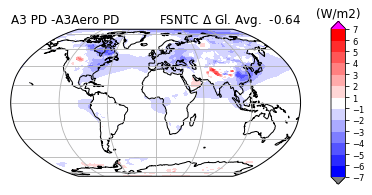

done withFSNTC



i LWCF
land only GA1 21.579271684584718
ocean only GA1 25.247824560068217
sea ice only GA1 18.360101084990173
land only GA2 22.189715453654014
ocean only GA2 25.758767896643505
sea ice only GA2 19.603880435920892
GA1, GA2, DG 23.90701113923464 24.47514341836045 0.568132279125809
DT.id LWCF
pltframe
pltframe plotOpt clevs [-5.0, -4.0, -3.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0]
data range -2.705532 6.6298027
pltframe final clevs [-5.0, -4.0, -3.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0]
pltframe done
figure being saved to  workdir/Test_Roblatlon_LWCF_ANN_FDIFS.pdf


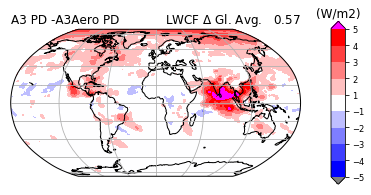

done withLWCF



i SWCF
land only GA1 -35.14893968510863
ocean only GA1 -53.89064479655299
sea ice only GA1 -30.75098220989809
land only GA2 -37.71402127064164
ocean only GA2 -55.6113786436426
sea ice only GA2 -31.58784946973121
GA1, GA2, DG -47.50020376872967 -49.43537799860134 -1.93517422987167
DT.id SWCF
pltframe
pltframe plotOpt clevs [-10.0, -8.0, -6.0, -4.0, -2.0, 2.0, 4.0, 6.0, 8.0, 10.0]
data range -15.826767 2.8233643
pltframe final clevs [-10.0, -8.0, -6.0, -4.0, -2.0, 2.0, 4.0, 6.0, 8.0, 10.0]
pltframe done
figure being saved to  workdir/Test_Roblatlon_SWCF_ANN_FDIFS.pdf


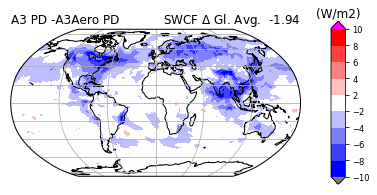

done withSWCF



i SOLIN
land only GA1 324.90565765003043
ocean only GA1 355.2118736045615
sea ice only GA1 198.51538193025192
land only GA2 324.90565765003043
ocean only GA2 355.2118736045615
sea ice only GA2 198.51538193025192
GA1, GA2, DG 340.3295840397743 340.3295840397743 0.0
DT.id SOLIN
pltframe
pltframe plotOpt clevs [-0.1  0.   0.1]
data range 0.0 0.0
pltframe final clevs [-0.1  0.   0.1]
pltframe done
figure being saved to  workdir/Test_Roblatlon_SOLIN_ANN_FDIFS.pdf


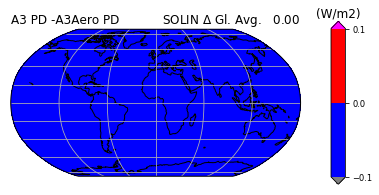

done withSolar Insolation



i TS
land only GA1 282.6777415079995
ocean only GA1 292.3351617329107
sea ice only GA1 263.43204031328
land only GA2 282.5604967507425
ocean only GA2 292.3380796641541
sea ice only GA2 263.975840477366
GA1, GA2, DG 288.39472354270885 288.38295312630083 -0.011770416408012352
DT.id TS
pltframe
pltframe plotOpt clevs [-1.0, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1.0]
data range -1.6835327 1.8399048
pltframe final clevs [-1.0, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1.0]
pltframe done
figure being saved to  workdir/Test_Roblatlon_TS_ANN_FDIFS.pdf


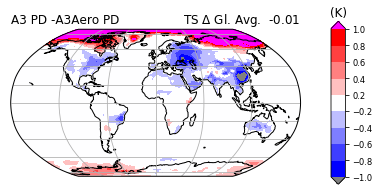

done withSurface Temperature



i TGCLDIWP
land only GA1 10.250673778440925
ocean only GA1 11.216179944434638
sea ice only GA1 6.182962223526957
land only GA2 10.391226005939783
ocean only GA2 11.479953921315486
sea ice only GA2 6.470071286655731
GA1, GA2, DG 10.740487378112743 10.968937597149743 0.22845021903700058
DT.id TGCLDIWP
pltframe
pltframe plotOpt clevs [-5.0, -2.0, -1.0, 1.0, 2.0, 5.0]
data range -2.4909744 4.397316
pltframe final clevs [-5.0, -2.0, -1.0, 1.0, 2.0, 5.0]
pltframe done
figure being saved to  workdir/Test_Roblatlon_TGCLDIWP_ANN_FDIFS.pdf


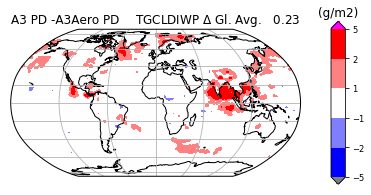

done withTGCLDIWP



i TGCLDLWP
land only GA1 37.49560596790236
ocean only GA1 56.86208950931309
sea ice only GA1 67.52897986439689
land only GA2 42.214982957477375
ocean only GA2 58.371267274070625
sea ice only GA2 75.16818524316619
GA1, GA2, DG 51.57723487972003 54.263628333452324 2.6863934537322933
DT.id TGCLDLWP
pltframe
pltframe plotOpt clevs [-25. -20. -15. -10.  -5.   5.  10.  15.  20.  25.]
data range -4.680603 29.2528
pltframe final clevs [-25. -20. -15. -10.  -5.   5.  10.  15.  20.  25.]
pltframe done
figure being saved to  workdir/Test_Roblatlon_TGCLDLWP_ANN_FDIFS.pdf


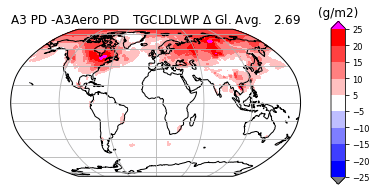

done withTGCLDLWP



i TREFHT
land only GA1 9.232594789097845
ocean only GA1 18.118045515543795
sea ice only GA1 -9.889171810491803
land only GA2 9.13737001989656
ocean only GA2 18.120174335997785
sea ice only GA2 -9.371673162587495
GA1, GA2, DG 14.438646928305095 14.431817870234218 -0.006829058070877636
DT.id TREFHT
pltframe
pltframe plotOpt clevs [-1.5 -1.  -0.5  0.5  1.   1.5]
data range -1.4256287 1.7525635
pltframe final clevs [-1.5 -1.  -0.5  0.5  1.   1.5]
pltframe done
figure being saved to  workdir/Test_Roblatlon_TREFHT_ANN_FDIFS.pdf


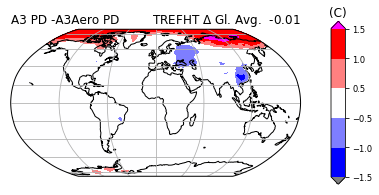

done withTREFHT





In [62]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
#vlist.append(vsets("SST", "SST","SST"))
vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
vlist.append(vsets("FLNT", "FLNT","FLNT"))
vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
vlist.append(vsets('LWCF', 'LWCF','LWCF'))
vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
vlist.append(vsets('SWCF', 'SWCF','SWCF'))
vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))

def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["ANN"]


for seas in seaslist:
    print "seas", seas

    # model1 dataset



    dir1 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850allF.ne30_oEC.edison/archive/atm/climo/rgr/"
    f1 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title1 = "A3AF PD "
    dir1 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3.ne30_oEC.edison/archive/atm/climo/rgr/"
    f1 = "20180716.DECKv1b_A3.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title1 = "A3 PD "
    f1 = "20180716.DECKv1b_A3.ne30_oEC.edison_"+seas+"_187001_188912_climo.nc"
    title1 = "A3 PI " 

    dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
    title1 = 'CAM5'


    dir1 = '/global/cscratch1/sd/leebrent/climos/output/20161118.beta0.F1850COSP.ne30_ne30.edison/'
    dir1 = '/global/cscratch1/sd/pjr/20161118.beta0.F1850COSP.ne30_ne30.edison/rgr/'
    f1 = '20161118.beta0.F1850COSP.ne30_ne30.edison_'+seas+'_climo.nc'
    title1 = 'F1850 '
    
    dir1 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850allF.ne30_oEC.edison/archive/atm/climo/rgr/"
    f1 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_187001_188912_climo.nc"
    title1 = "A3AF PI "
    f1 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title1 = "A3AF PD "

    dir1 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850aeroF.ne30_oEC.edison/archive/atm/climo/rgr/"
    f1 = "20180716.DECKv1b_A3_1850aeroF.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title1 = "A3Aero PD "
    
    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname1", jname1
    varlist = g1.listvariables();
    varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
    print "g1 varlist", varlist
    dims = g1.listdimension();


    # model2 dataset

    dir2 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850allF.ne30_oEC.edison/archive/atm/climo/rgr/"

    dir2 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850allF.ne30_oEC.edison/archive/atm/climo/rgr/"
    f2 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title2 = "A3AF PD "
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    title2 = "beta PD"
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20161118.beta0.F2000AFCOSP.ne30_ne30.edison/rgr/'
    f2 = '20161118.beta0.F2000AFCOSP.ne30_ne30.edison_ANN_000112_001111_climo.nc'
    title2 = 'F2000AF '
    dir2 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3_1850allF.ne30_oEC.edison/archive/atm/climo/rgr/"
    f2 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_187001_188912_climo.nc"
    title2 = "A3AF PI "
    f2 = "20180716.DECKv1b_A3_1850allF.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title2 = "A3AF PD "

    dir2 = "/global/cscratch1/sd/pjr/20180716.DECKv1b_A3.ne30_oEC.edison/archive/atm/climo/rgr/"
    f2 = "20180716.DECKv1b_A3.ne30_oEC.edison_"+seas+"_198001_200412_climo.nc"
    title2 = "A3 PD "
  

    
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2  


    for i in vlist:
#       fig, ax3, cx3 = setup3()
        fig, ax1, cx1 = setup1()
        vname = i.mname
        print "i", vname
        ltit1 = title1+vname
        ltit2 = title2+vname
        ltitD = title2+"-"+title1
        
        pltname = "workdir/Test_Roblatlon_"+i.mname+"_"+seas+"_FDIFS.pdf"
        LF1 = getfld(g1,"LANDFRAC")
        OF1 = getfld(g1,"OCNFRAC")
        IF1 = getfld(g1,"ICEFRAC")
#       print "LF1 range", LF1.min(), LF1.max()

        T1 = getfld (g1, vname)
#       print " loop T1.info", T1.info()

        GA1 = cdutil.averager(T1,axis="xy")

        T2 = getfld (g2, vname)
        if T1.shape != T2.shape:
            print "T1 and T2 shapes differ", T1.shape, T2.shape
            1./0.
            
        LF2 = getfld(g2,"LANDFRAC")
        OF2 = getfld(g2,"OCNFRAC")
        IF2 = getfld(g2,"ICEFRAC")
        LLW1 = cdutil.area_weights(T1)[:] #lat lon weights
        LLLW1 = LLW1*LF1; LLLW1 = LLLW1/LLLW1.sum(); # Land weights sum to one over land pts
        OLLW1 = LLW1*OF1; OLLW1 = OLLW1/OLLW1.sum(); # Ocean weights sum to one over ocean pts
        ILLW1 = LLW1*IF1; ILLW1 = ILLW1/ILLW1.sum(); # Sea Ice weights sum to one over ice pts
        latlonwts = cdutil.area_weights(T1)[:]
#        print "shape", latlonwts.shape
#        print "range", latlonwts.min(), latlonwts.max()
#        print "sum", latlonwts.sum()
#        print "GA using latlonwts", cdutil.averager(T1,axis="xy",weights=latlonwts)
#        llw2 = latlonwts*LF1
#        llw2 = llw2/llw2.sum()
#        print "llw2 sum", llw2.sum()
        print "land only GA1", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "ocean only GA1", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "sea ice only GA1", cdutil.averager(T1,axis="xy",weights=ILLW1)
#        print "latlonwts shape and range", dir(latlonwts)# .shape() #, latlonwts.min(), latlonwts.max()

        maskon = False
        if maskon is True:
            print "***** MASKING T1"
            mlist = (LF1[:] < 0.5) # mask out values less than this number
            mlist = (IF1[:] < 0.1) # mask out values less than this number
            mlist = (OF1[:] < 1.) # mask out values less than this number
#            print "mlist",mlist[0,0],mlist[-1,-1]
#            print "mask shape", mlist.shape
            T1.mask = mlist # add a mask
            ltit1 = ltit1 + " masked"
            print "global average after a mask is added", cdutil.averager(T1,axis="xy")
            print "global average in land region after a mask is added", cdutil.averager(T1,axis="xy",weights=LLLW1)
            print "global average in ocean region after a mask is added", cdutil.averager(T1,axis="xy",weights=OLLW1)
            print "global average in ice region after a mask is added", cdutil.averager(T1,axis="xy",weights=ILLW1)
            print "***** MASKING T2"
            mlist = (LF2[:] < 0.5) # mask out values less than this number
            mlist = (IF2[:] < 0.1) # mask out values less than this number
            mlist = (OF2[:] < 1.) # mask out values less than this number
#            print "mlist",mlist[0,0],mlist[-1,-1]
#            print "mask shape", mlist.shape
            T2.mask = mlist # add a mask
            print "global average after a mask is added", cdutil.averager(T2,axis="xy")
            print "global average in land region after a mask is added", cdutil.averager(T2,axis="xy",weights=LLLW1)
            print "global average in ocean region after a mask is added", cdutil.averager(T2,axis="xy",weights=OLLW1)
            print "global average in ice region after a mask is added", cdutil.averager(T2,axis="xy",weights=ILLW1)
            ltit2 = ltit2 + " masked"

        GA1 = cdutil.averager(T1,axis="xy")
        GA2 = cdutil.averager(T2,axis="xy")
        rtit1 = "Gl. Avg. %6.2f"%GA1
        rtit2 = "Gl. Avg. %6.2f"%GA2
        print "land only GA2", cdutil.averager(T2,axis="xy",weights=LLLW1)
        print "ocean only GA2", cdutil.averager(T2,axis="xy",weights=OLLW1)
        print "sea ice only GA2", cdutil.averager(T2,axis="xy",weights=ILLW1)

        DT = T2 - T1
        DT.id = T1.id

        
        DG = GA2 - GA1
        print "GA1, GA2, DG", GA1, GA2, DG
        rtitD = i.mname+" $\Delta$ Gl. Avg. %6.2f"%DG

        pltdat1(T1, T2, DT)
        

        print "figure being saved to ", pltname
        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        x = plt.show()
        print "done with"+i.name+"\n\n\n"
#       break


In [ ]:
    # model2 dataset
    dir1 = '/global/cscratch1/sd/leebrent/climos/output/20161118.beta0.F1850COSP.ne30_ne30.edison/'
    f1 = '20161118.beta0.F1850COSP.ne30_ne30.edison_'+seas+'_climo.nc'
    title1 = 'F1850 '
    
    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname2", jname2 
    
    V1 = g1('LWCF',squeeze=1)

    G1 = cdutil.averager(V1,axis="xy")
    print "G1", G1
    
    
    

In [6]:
# disabled
1./0.

# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets('SWCF', 'SWCF','SWCF'))
vlist.append(vsets('LWCF', 'LWCF','LWCF'))
vlist.append(vsets("FSNT", "FSNT","FSNT"))
vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
#vlist.append(vsets("SST", "SST","SST"))
vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
vlist.append(vsets("FLNT", "FLNT","FLNT"))
vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))

#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["ANN"]


for seas in seaslist:
    print "seas", seas


    # model1 dataset
    dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"


    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname1", jname1
    varlist = g1.listvariables();
    varlist = [x for x in varlist if re.match(r'^.*IC',x)]
#    print "g1 varlist", varlist
#    dims = g1.listdimension();


    # model2 dataset
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2  

    title = ""
    
    fig, ax3, cx3 = setup3()
    for i in vlist:
        vname = i.mname
        print "i", vname 
        pltname = "Roblatlon_"+i.name+"_"+seas+"_FDIFS.pdf"
        LF1 = getfld(g1,"LANDFRAC")
        OF1 = getfld(g1,"OCNFRAC")
        IF1 = getfld(g1,"ICEFRAC")
        print "LF1 range", LF1.min(), LF1.max()

        T1 = getfld (g1, vname)
        if vname is "TREFHT":
            T1 = T1 - 273.15
            T1.units = "C"
        ltit1 = "CAM5 "+vname
        GA1 = cdutil.averager(T1,axis="xy")
        T2 = getfld (g1, vname)
        if vname is "TREFHT":
            T2 = T2 - 273.15
            T2.units = "C"
        LLW1 = cdutil.area_weights(T1)[:] #lat lon weights
        LLLW1 = LLW1*LF1; LLLW1 = LLLW1/LLLW1.sum(); # Land weights sum to one over land pts
        OLLW1 = LLW1*OF1; OLLW1 = OLLW1/OLLW1.sum(); # Ocean weights sum to one over ocean pts
        ILLW1 = LLW1*IF1; ILLW1 = ILLW1/ILLW1.sum(); # Sea Ice weights sum to one over ice pts
        latlonwts = cdutil.area_weights(T1)[:]
#        print "shape", latlonwts.shape
#        print "range", latlonwts.min(), latlonwts.max()
#        print "sum", latlonwts.sum()
#        print "GA using latlonwts", cdutil.averager(T1,axis="xy",weights=latlonwts)
#        llw2 = latlonwts*LF1
#        llw2 = llw2/llw2.sum()
#        print "llw2 sum", llw2.sum()
        print "land only GA", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "ocean only GA", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "sea ice only GA", cdutil.averager(T1,axis="xy",weights=ILLW1)
#        print "latlonwts shape and range", dir(latlonwts)# .shape() #, latlonwts.min(), latlonwts.max()
    
        mlist = (LF1[:] < 0.5) # mask out values less than this number
        mlist = (IF1[:] < 0.1) # mask out values less than this number
        print "mlist",mlist[0,0],mlist[-1,-1]
        print "mask shape", mlist.shape
        T2.mask = mlist # add a mask for land points
        ltit1 = "CAM5 "+vname
        ltit2 = "masked CAM5"
        GA2 = cdutil.averager(T2,axis="xy")
        DT = T2 - T1
        DG = GA2 - GA1
        print "GA1, masked GA1, DG", GA1, GA2, DG
        pltdat(T1, T2, DT)
        
        T1.mask = mlist
        print "global average after a mask is added", cdutil.averager(T1,axis="xy")
        print "global average in land region after a mask is added", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "global average in ocean region after a mask is added", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "global average in ice region after a mask is added", cdutil.averager(T1,axis="xy",weights=ILLW1)

#        print "figure being saved to ", pltname
#        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        print "done with"+i.name
        break


ZeroDivisionError: float division by zero